# Задание 6. Фильтр Калмана для модели кардиостимулятора, используемого для стимуляции узла SA

In [1]:
import matlab.engine
import numpy as np
import math
import matplotlib.pyplot as plt
import control

## Объявление и определение используемых функций и параметров

In [2]:
alpha = 1
e = 3.5
d = 3.0
nu = 1
v1 = 0.83
v2 = -0.85
t = [i for i in np.arange(0, 100, 0.01)]
y = 0.5
rho = 1
omega = math.pi/2

def modelWithKalmanFilter(inputSys):
    sys = control.tf2ss(inputSys)
    A, B, C, D = control.ssdata(sys)

    Plant = eng.ss(matlab.double(A.tolist()), 
                   matlab.double(np.c_[B, B].tolist()), 
                   matlab.double(C.tolist()), 
                   0,'inputname',{'u' 'w'},'outputname','y')

    Q = matlab.double([1])
    R = matlab.double([0.1])

    # L, P, E = control.lqe(sys, Q, R)
    # print(L, P, E, sep='\n')

    kalmf = eng.kalman(Plant, Q, R)

    a = matlab.double(A.tolist())  
    b = matlab.double(np.c_[B, np.c_[B, 0*B]].tolist()) 
    c = matlab.double(np.r_[C, C].tolist())  
    d = matlab.double([[0, 0, 0],
                       [0, 0, 1]])

    P = eng.ss(a, b, c, d, 'inputname',{'u' 'w' 'v'},'outputname',{'y' 'yv'})  

    eng.workspace['P'] = P
    eng.workspace['kalmf'] = kalmf
    sys = eng.eval('parallel(P,kalmf,1,1,[],[])')

    SimModel = eng.feedback(sys,1,4,2,1)
    eng.workspace['SimModel'] = SimModel
    SimModel = eng.eval('SimModel([1 3], [1 2 3])')

    w = np.random.normal(0, Q, (len(t), 1))
    v = np.random.normal(0, R, (len(t), 1))

    inputData = matlab.double(np.c_[w, np.c_[v, u]].tolist())

    out = np.array(eng.lsim(SimModel, inputData, matlab.double(t), 'zoh'))
    
    return out, v

def drawResults(modelOut, measNoise):
    noiseY = out[:, 0] + measNoise[:, 0]

    plt.figure(figsize=(20, 10))
    plt.plot(t, out[:, 0], "g")
    plt.plot(t, out[:, 1], "r")
    plt.title('Выход системы') 
    plt.ylabel('Значение выхода')
    plt.xlabel('Воемя')
    plt.grid(True)
    plt.show()

    errModel = out[:, 0] - noiseY
    errEst = out[:, 0] - out[:, 1]

    plt.figure(figsize=(20, 10))
    plt.plot(t, errModel, "g")
    plt.plot(t, errEst, "r")
    plt.title('Ошибка модели и оценки Калмана') 
    plt.ylabel('Ошибка')
    plt.xlabel('Время')
    plt.grid(True)
    plt.show()

## Запуск ядра MATLAB для некоторых функций

In [3]:
eng = matlab.engine.start_matlab()

## Модель системы с фильтром Калмана 
### Управление вида: $u(t) = 1(t)$

#### Передаточная функция

In [4]:
s1 = [((2.1*alpha)/6)*(2*y**3 - 3*(v1 + v2)*y**2 + 6*v1*v2*y) + 1.1 - ((3*y**2)/(d*e)) - ((2*y*(e+d)/(d*e)))]
s2 = [1, 0, 2.1]

sys1 = control.tf(s1, s2);
print(sys1)


 -0.2385
---------
s^2 + 2.1



#### Отклик системы

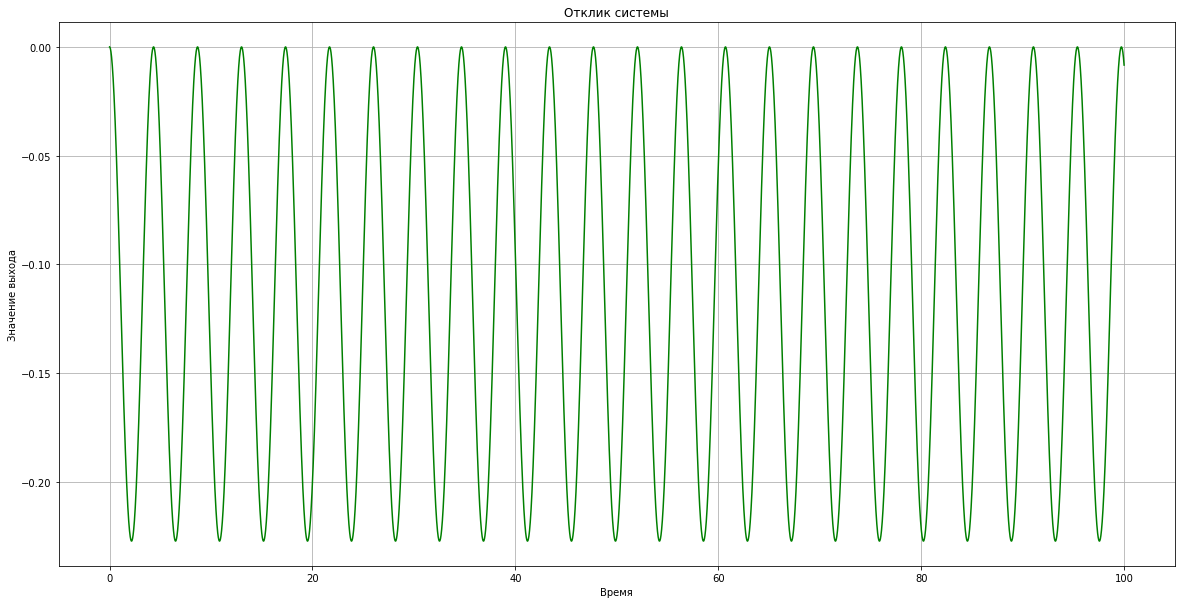

In [5]:
u = [1 for dt in t]

out = control.forced_response(sys1, t, u)[1]

plt.figure(figsize=(20, 10))
plt.plot(t, out, "g")
plt.title('Отклик системы') 
plt.ylabel('Значение выхода')
plt.xlabel('Время')
plt.grid(True)
plt.show()

#### Выход системы (зеленый) и оценка фильтра Калмана (красный)

> In DynamicSystem/plusInput (line 732)
In DynamicSystem/plusMetaData (line 568)
In + (line 58)
In InputOutputModel/parallel (line 104)


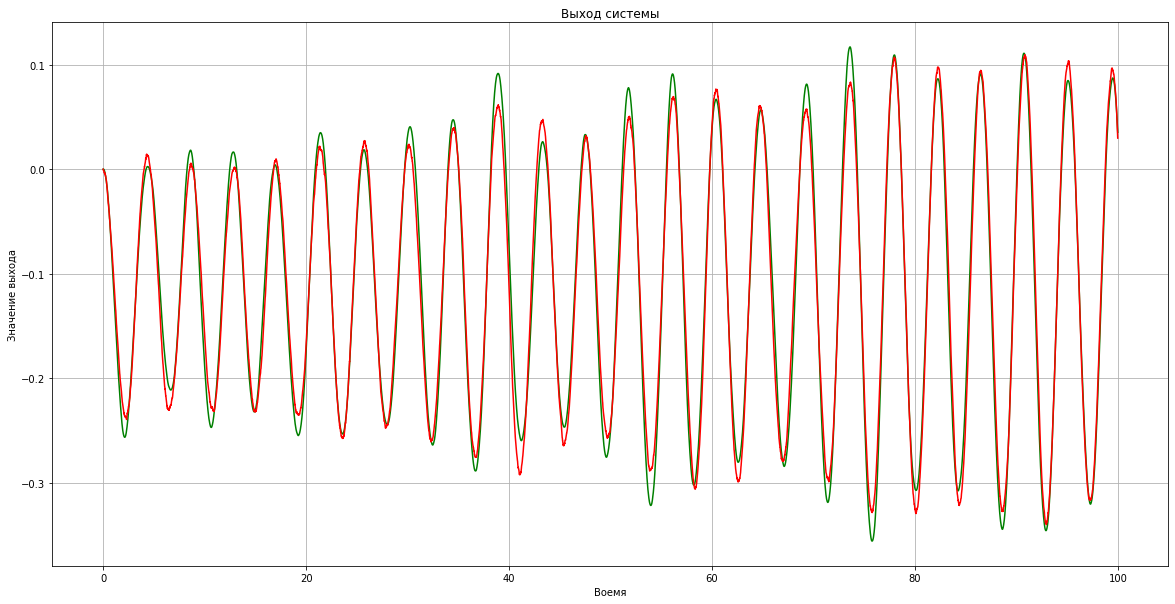

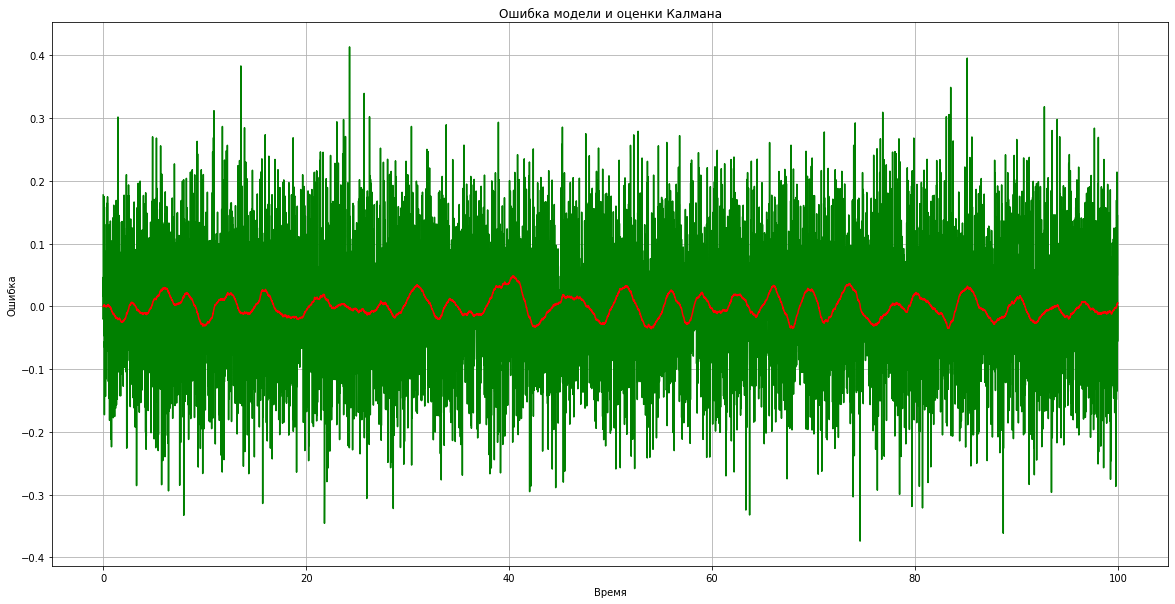

In [6]:
out, noise = modelWithKalmanFilter(sys1)
drawResults(out, noise)

### Управление вида: $u(t) = \rho sin(\omega t)$

#### Передаточная функция

In [7]:
s1 = [2.1*y - (y*(y + d)*(y + e))/(d*e), ((2.1*alpha)/6)*(2*y ** 3 - 3*(v1 + v2)*y ** 2 + 6*v1*v2*y) + 1.1 - ((3*y ** 2)/(d*e)) - ((2*y*(e+d)/(d*e)))];
s2 = [1, 0, 2.1]

sys1 = control.tf(s1, s2);
print(sys1)


0.3833 s - 0.2385
-----------------
    s^2 + 2.1



#### Отклик системы

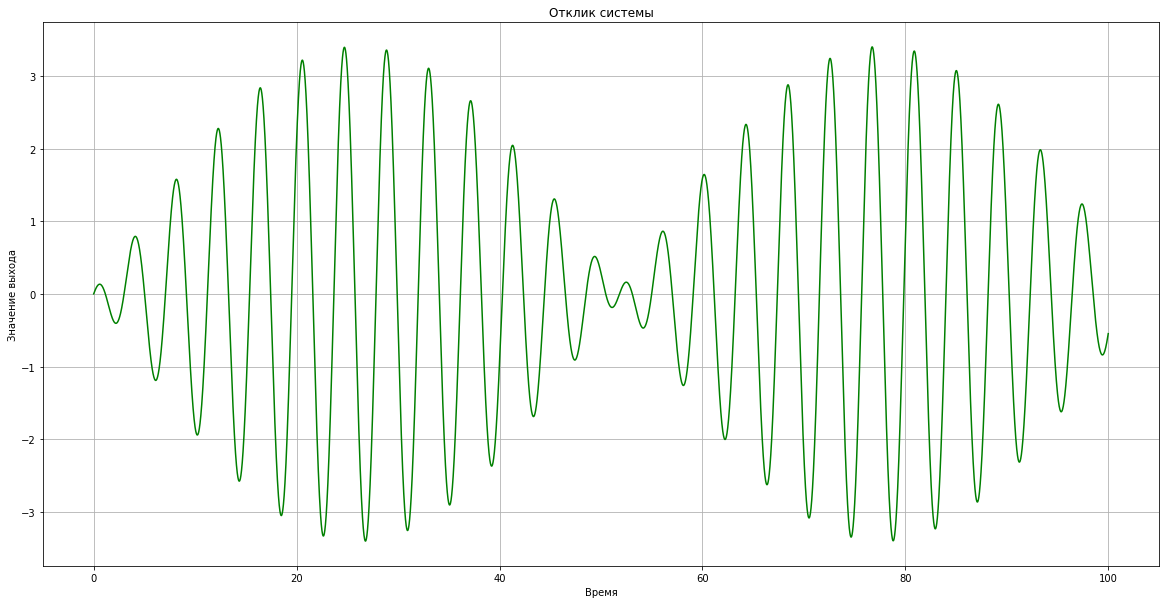

In [8]:
u = [rho * math.cos(omega * dt) for dt in t]

out = control.forced_response(sys1, t, u)[1]

plt.figure(figsize=(20, 10))
plt.plot(t, out, "g")
plt.title('Отклик системы') 
plt.ylabel('Значение выхода')
plt.xlabel('Время')
plt.grid(True)
plt.show()

#### Выход системы (зеленый) и оценка фильтра Калмана (красный)

> In DynamicSystem/plusInput (line 732)
In DynamicSystem/plusMetaData (line 568)
In + (line 58)
In InputOutputModel/parallel (line 104)


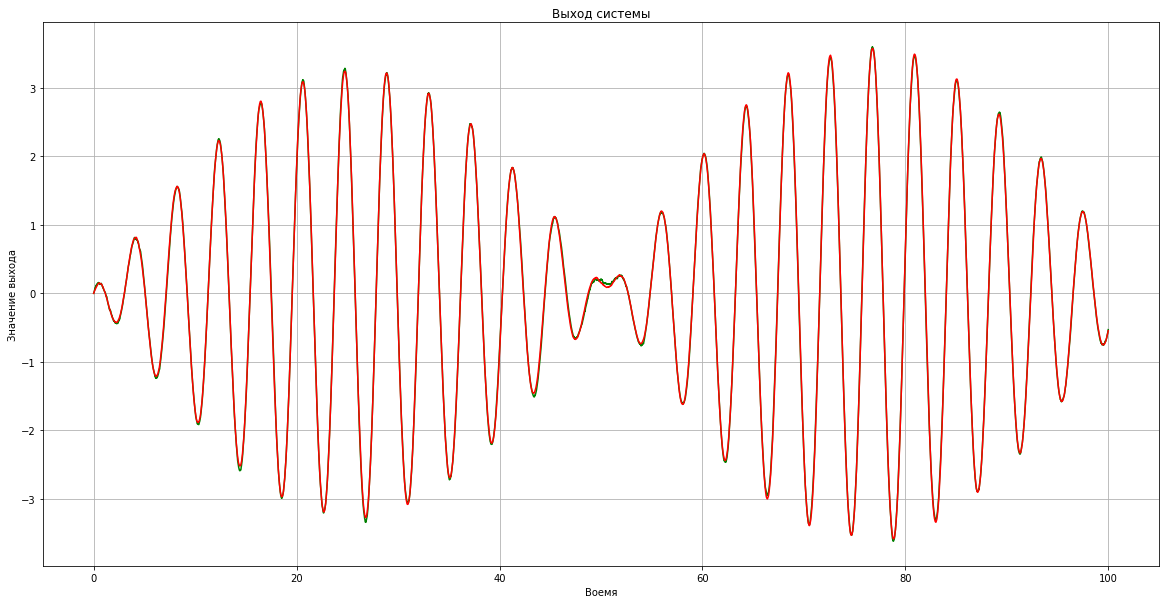

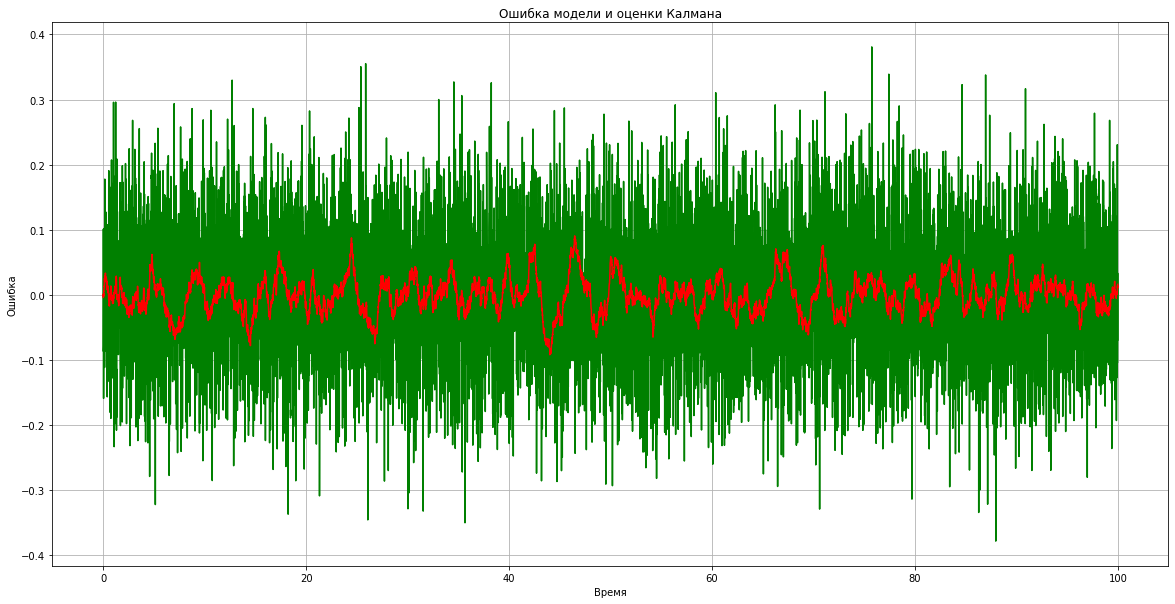

In [9]:
out, noise = modelWithKalmanFilter(sys1)
drawResults(out, noise)

## Завершение ядра MATLAB

In [10]:
eng.quit()